In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import load_img
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = '../input/fer2013/train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 22968 images belonging to 7 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../input/fer2013/train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 5741 images belonging to 7 classes.


In [5]:
test_dataset = test_datagen.flow_from_directory(directory = '../input/fer2013/test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


(48, 48, 3)
(1, 48, 48, 3)


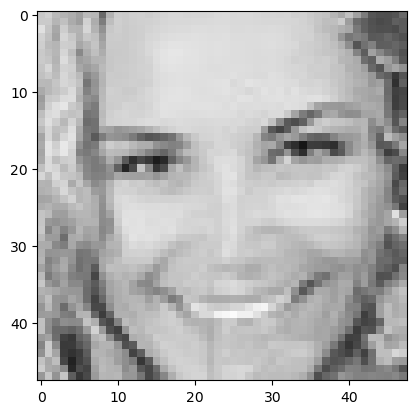

In [6]:
from tensorflow.keras.preprocessing import image
img = image.load_img("/kaggle/input/fer2013/test/happy/PrivateTest_10077120.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(48, 48, 3), include_top=False, weights=None)



In [8]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [9]:
model=Sequential()

model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

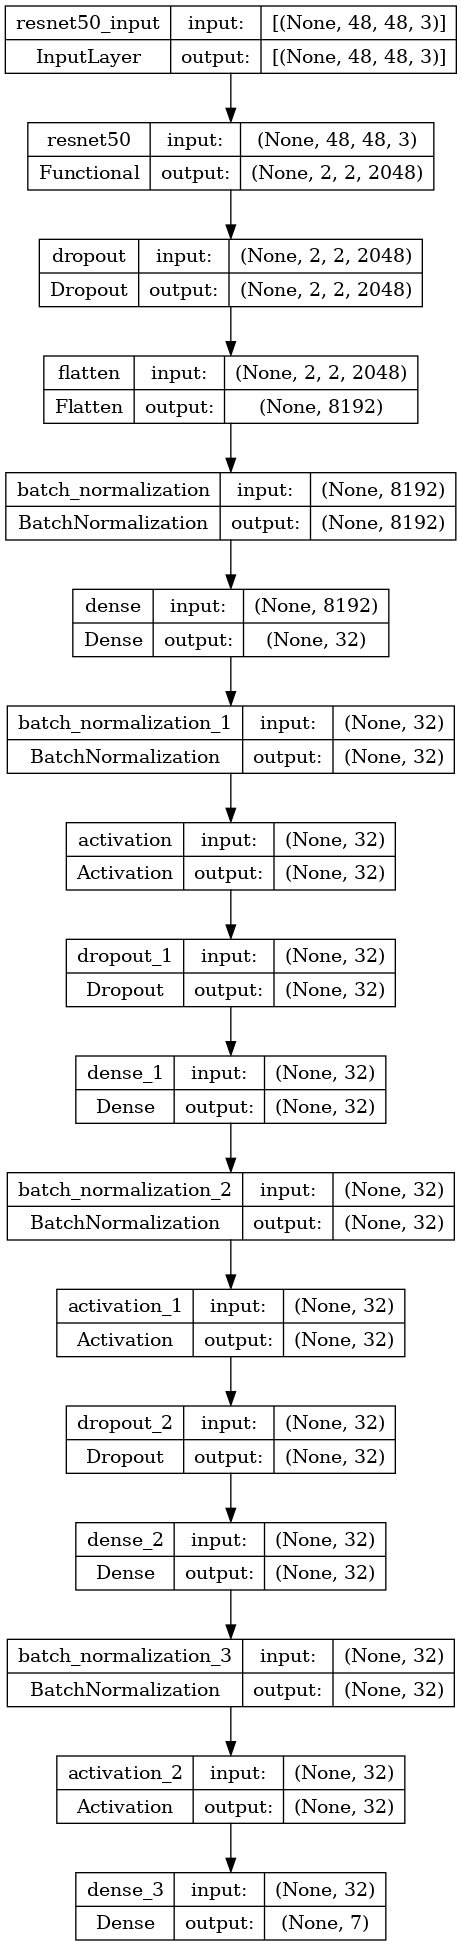

In [11]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 


In [12]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [13]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [14]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [15]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [16]:
history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 10,verbose = 1,callbacks=[lrd,mcp,es])



Epoch 1/10
359/359 [==============================] - 284s 775ms/step - loss: 1.9055 - accuracy: 0.8549 - precision: 0.1437 - recall: 0.0031 - auc: 0.6167 - f1_score: 0.0059 - val_loss: 1.8564 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6427 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/10
359/359 [==============================] - 133s 371ms/step - loss: 1.8170 - accuracy: 0.8571 - precision: 0.2941 - recall: 4.3539e-04 - auc: 0.6498 - f1_score: 8.5578e-04 - val_loss: 1.8204 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6527 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/10
359/359 [==============================] - 147s 408ms/step - loss: 1.8029 - accuracy: 0.8571 - precision: 0.2857 - recall: 8.7078e-05 - auc: 0.6565 - f1_score: 1.7142e-04 - val_loss: 1.7890 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6669 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epo

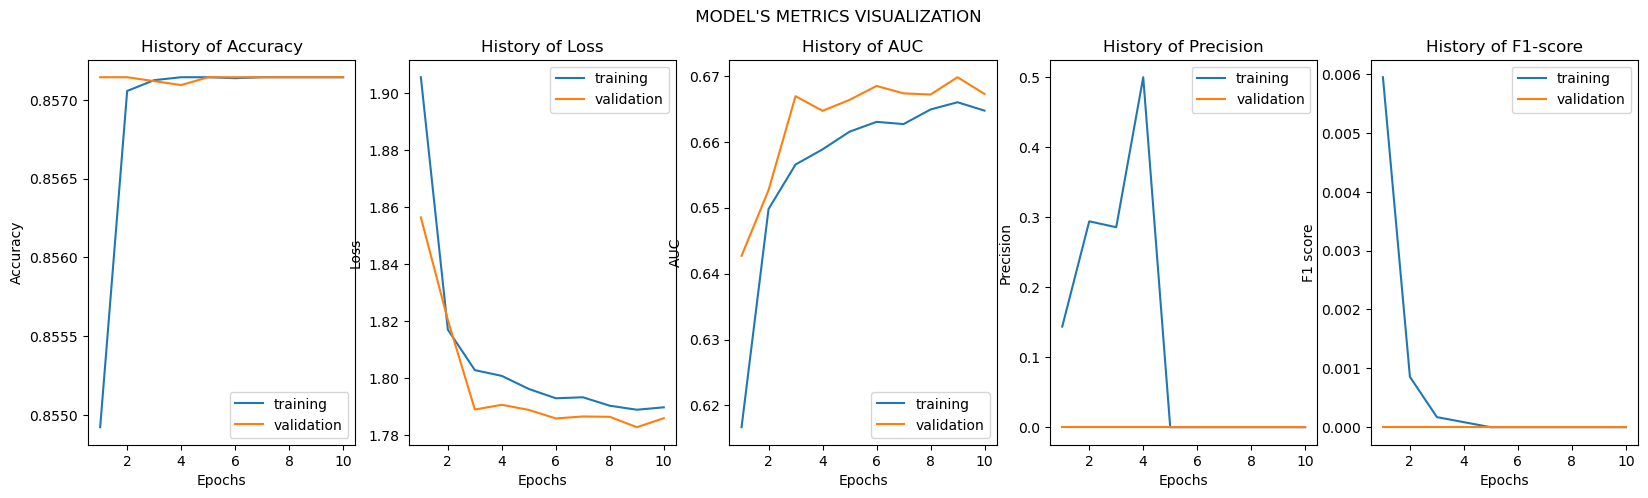

In [17]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

In [19]:
history.history['accuracy']

[0.854922354221344,
 0.8570557832717896,
 0.8571242094039917,
 0.8571428656578064,
 0.8571428656578064,
 0.8571366667747498,
 0.8571428656578064,
 0.8571428656578064,
 0.8571428656578064,
 0.8571428656578064]

In [20]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the image
img = image.load_img("/kaggle/input/fer2013/test/happy/PrivateTest_10077120.jpg", target_size=(48, 48))

# Convert the image to an array and preprocess it
img_array = image.img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

import tensorflow as tf

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.round(tf.clip_by_value(y_pred, 0, 1))
    tp = tf.reduce_sum(y_true * y_pred)
    fp = tf.reduce_sum(y_pred) - tp
    fn = tf.reduce_sum(y_true) - tp
    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
    return f1


# Load the model
from keras.models import load_model

model_path = '/kaggle/input/modelh5/model.h5'
model = load_model(model_path, custom_objects={'f1_score': f1_score})


# Make predictions
predictions = model.predict(img_array)
max_index = np.argmax(predictions[0])
emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise')
emotion_prediction = emotion_detection[max_index]
print("Predicted emotion:", emotion_prediction)


1/1 [==============================] - 1s 1s/step
Predicted emotion: happy
